## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

Using TensorFlow backend.


## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 456
WIDTH = 456
CHANNELS = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LR_WARMUP_EPOCHS_1st = 3
LR_WARMUP_EPOCHS_2nd = 5
WARMUP_BATCHES_1st = LR_WARMUP_EPOCHS_1st * len(X_train) // BATCH_SIZE
WARMUP_BATCHES_2nd = LR_WARMUP_EPOCHS_2nd * len(X_train) // BATCH_SIZE

# Pre-procecess images

In [4]:
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
    
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
# Pre-procecss train set
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss validation set
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss test set
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)

# Data generator

In [5]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                          dataframe=X_train,
                          directory=train_dest_path,
                          x_col="id_code",
                          y_col="diagnosis",
                          class_mode="raw",
                          batch_size=BATCH_SIZE,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                          dataframe=test,
                          directory=test_dest_path,
                          x_col="id_code",
                          batch_size=1,
                          class_mode=None,
                          shuffle=False,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


In [6]:
class WarmUpLearningRateScheduler(Callback):
    def __init__(self, warmup_batches, init_lr, verbose=0):
        """
        Constructor for warmup learning rate scheduler
        :param warmup_batches {int}: Number of batch for warmup.
        :param init_lr {float}: Learning rate after warmup.
        :param verbose {int}: 0: quiet, 1: update messages. (default: {0})
        """
        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count * self.init_lr / self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %02d: WarmUpLearningRateScheduler setting learning rate to %s.' % (self.batch_count + 1, lr))

# Model

In [7]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

warmup_lr_1st = WarmUpLearningRateScheduler(WARMUP_BATCHES_1st, WARMUP_LEARNING_RATE)

metric_list = ["accuracy"]
callback_list = [warmup_lr_1st]
optimizer = optimizers.RMSprop(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     callbacks=callback_list,
                                     verbose=2).history

Epoch 1/5
 - 193s - loss: 1.3047 - acc: 0.4467 - val_loss: 1.5487 - val_acc: 0.2294
Epoch 2/5
 - 179s - loss: 1.0111 - acc: 0.4406 - val_loss: 2.2136 - val_acc: 0.3807
Epoch 3/5
 - 179s - loss: 0.9923 - acc: 0.4525 - val_loss: 1.5803 - val_acc: 0.2290
Epoch 4/5
 - 178s - loss: 0.9983 - acc: 0.4594 - val_loss: 1.4889 - val_acc: 0.2152
Epoch 5/5
 - 178s - loss: 0.9621 - acc: 0.4805 - val_loss: 1.6063 - val_acc: 0.2069


# Fine-tune the complete model

In [10]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
warmup_lr_2nd = WarmUpLearningRateScheduler(WARMUP_BATCHES_2nd, LEARNING_RATE)

callback_list = [es, rlrop, warmup_lr_2nd]
optimizer = optimizers.RMSprop(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [11]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=2).history

Epoch 1/40
 - 408s - loss: 0.8468 - acc: 0.5154 - val_loss: 0.7562 - val_acc: 0.4938
Epoch 2/40
 - 365s - loss: 0.6713 - acc: 0.5680 - val_loss: 0.5984 - val_acc: 0.6041
Epoch 3/40
 - 366s - loss: 0.6283 - acc: 0.6025 - val_loss: 0.6314 - val_acc: 0.6359
Epoch 4/40
 - 366s - loss: 0.5558 - acc: 0.6387 - val_loss: 0.5262 - val_acc: 0.6331
Epoch 5/40
 - 366s - loss: 0.5120 - acc: 0.6622 - val_loss: 0.5074 - val_acc: 0.6690
Epoch 6/40
 - 364s - loss: 0.4500 - acc: 0.6916 - val_loss: 0.4254 - val_acc: 0.7117
Epoch 7/40
 - 364s - loss: 0.4046 - acc: 0.7059 - val_loss: 0.3596 - val_acc: 0.7503
Epoch 8/40
 - 364s - loss: 0.4065 - acc: 0.7152 - val_loss: 0.3631 - val_acc: 0.7255
Epoch 9/40
 - 364s - loss: 0.3700 - acc: 0.7261 - val_loss: 0.3400 - val_acc: 0.7586
Epoch 10/40
 - 364s - loss: 0.3524 - acc: 0.7370 - val_loss: 0.3000 - val_acc: 0.7641
Epoch 11/40
 - 363s - loss: 0.3260 - acc: 0.7493 - val_loss: 0.3156 - val_acc: 0.7848
Epoch 12/40
 - 363s - loss: 0.2879 - acc: 0.7582 - val_loss: 0.

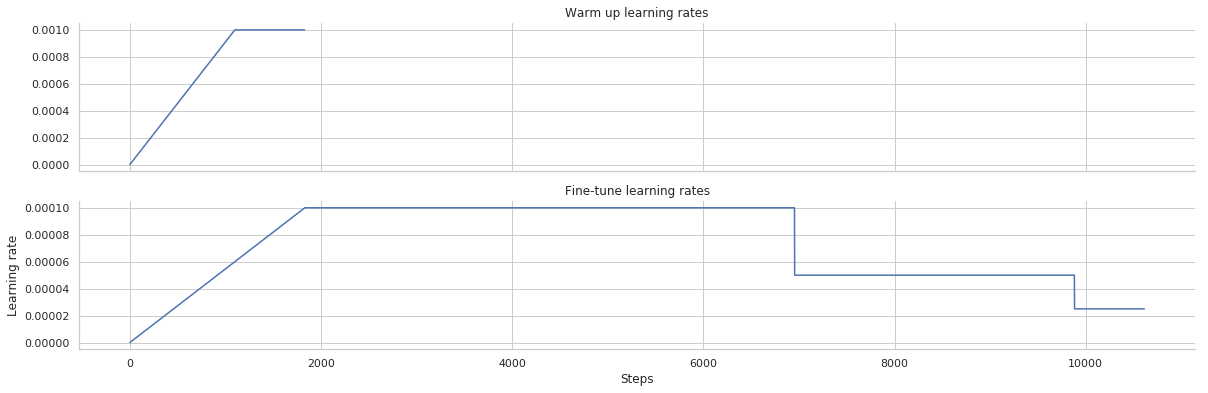

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 6))

ax1.plot(warmup_lr_1st.learning_rates)
ax1.set_title('Warm up learning rates')

ax2.plot(warmup_lr_2nd.learning_rates)
ax2.set_title('Fine-tune learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

# Model loss graph 

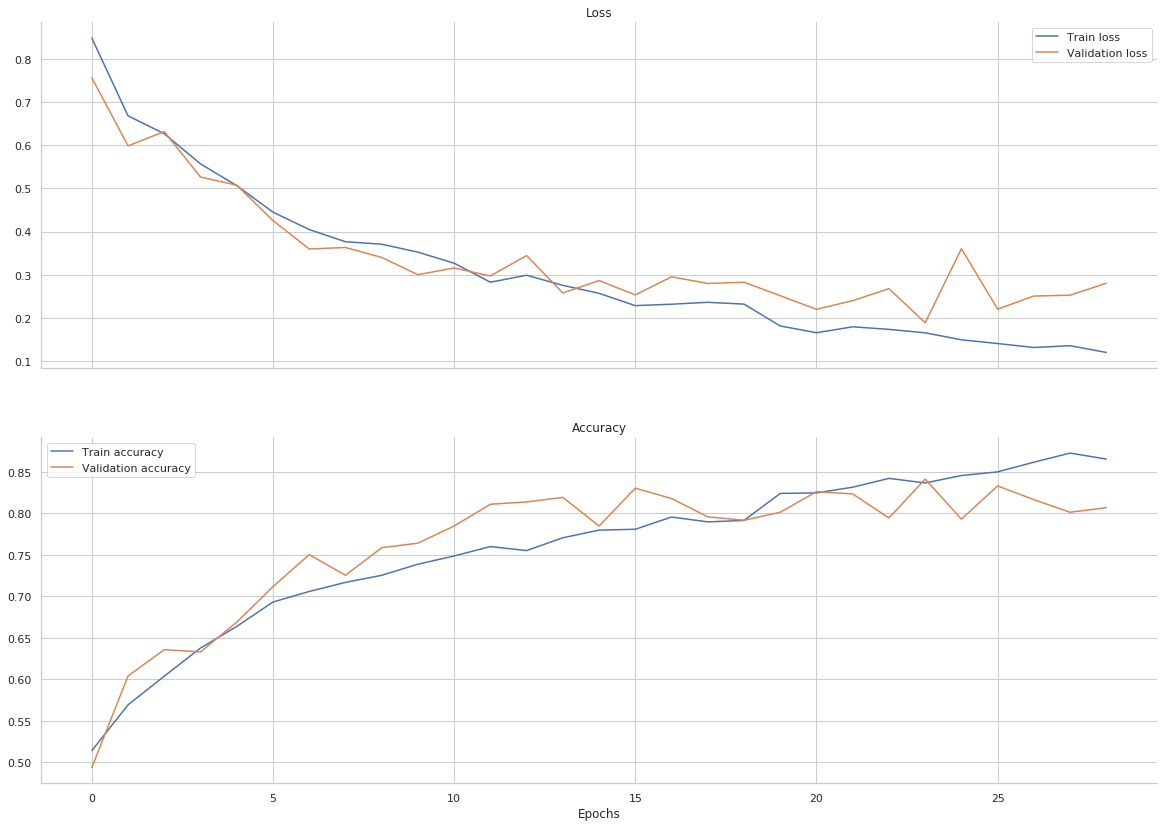

In [13]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

### Original thresholds

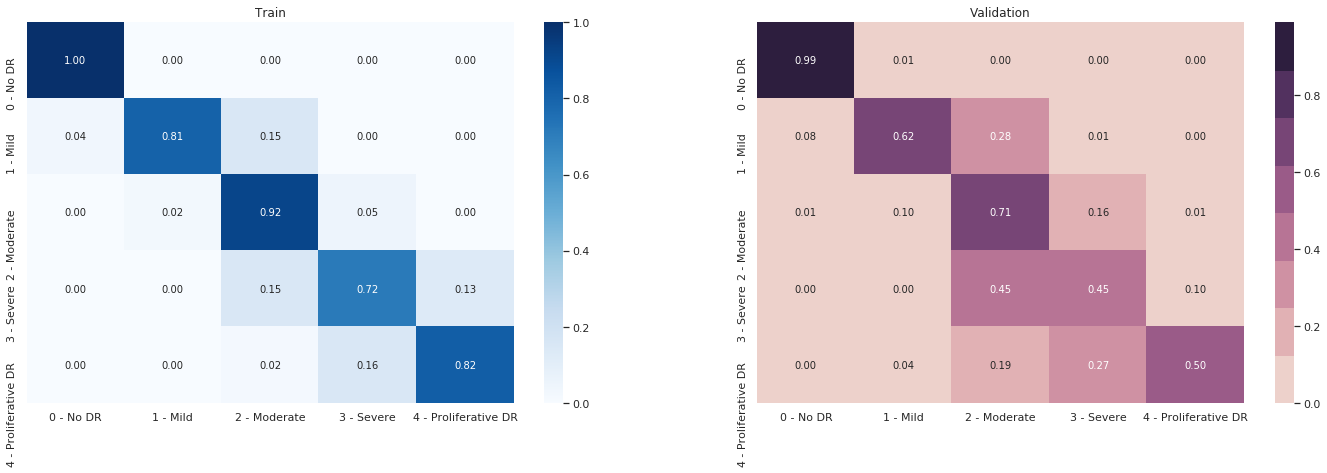

In [16]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

## Quadratic Weighted Kappa

In [17]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

Train        Cohen Kappa score: 0.976
Validation   Cohen Kappa score: 0.908
Complete set Cohen Kappa score: 0.962


## Apply model to test set and output predictions

In [18]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator)
predictions = [classify(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

In [19]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

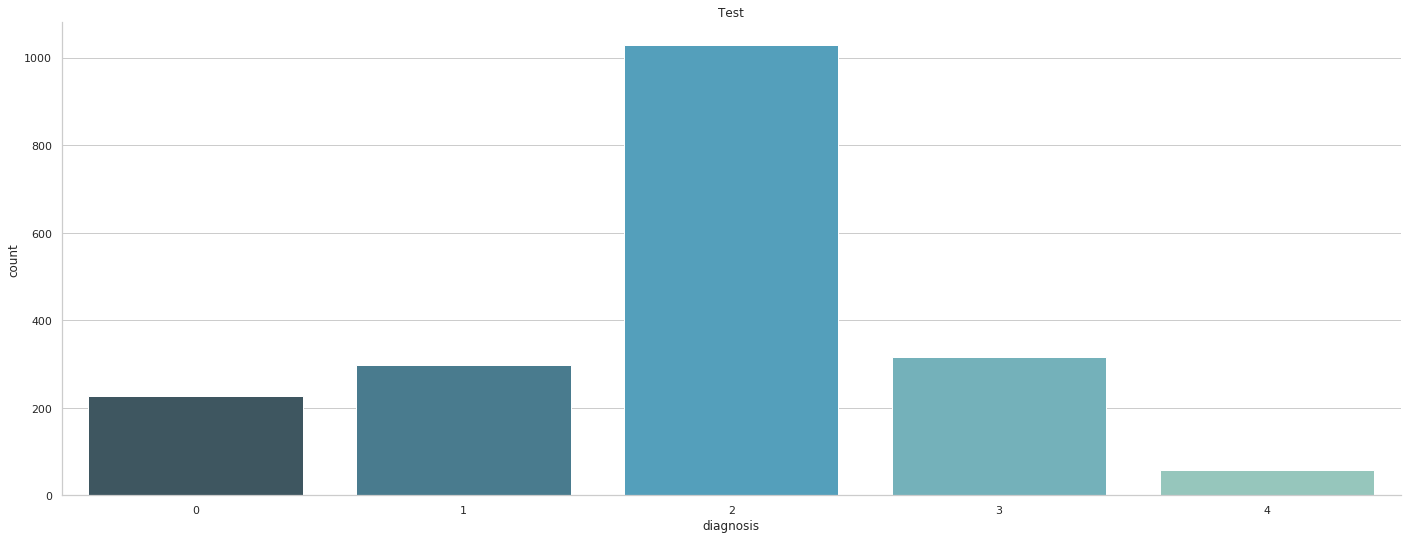

In [20]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

In [21]:
results.to_csv('submission.csv', index=False)
display(results.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,3
4,009245722fa4,2
